# Estudio de la evolución de la pandemia por el modelo de red neuronal recurrente para la isla de Tenerife

In [3]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [31]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.legend()
    plt.show()
    
def visualizar_historico(train, y_test, y_pred, variable, dias_historico, indices, tit, color, dif):
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color_isla)
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color_isla)
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    plt.bar(indices, dif, width=0.5, color='black', alpha=0.2, align='edge', label='Diferencia')
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=70)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.1))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.1))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.1))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32, verbose=1)
    
    return modelo
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_resultados_texto(y_test, y_pred, fechas):
    for i in range(len(y_test)):
        print(str(fechas[i]) + ': número de casos reales ' + str(int(y_test[i][0])) + ', número de casos predichos ' + str(y_pred[i][0]))

In [5]:
# Cargamos los datos de las estaciones de cada una de las islas
datos_islas = pd.read_csv('../data/Final/datos_final.csv', header=0)

# Obtenemos los datos de la isla a la que se le va a realizar el estudio
datos_Tenerife = datos_islas[datos_islas['isla'] == 'TENERIFE']

# Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_Tenerife = datos_Tenerife.sort_values(by='fecha')

datos_Tenerife = datos_Tenerife.set_index('fecha') # Asignamos la fecha como índice

In [6]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a predecir y a agrupar para cada predicción
isla = 'Tenerife'         # Isla a la que se está realziando el estudio
fechas = datos_Tenerife.tail(dias_prediccion).index # Fechas de los días a predecir
color_isla = 'dodgerblue'


variables_covid = [objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']    # Atributos para el análisis de las variables pandémicas
variables_atm = [objetivo, 'tmin', 'tmed', 'presMax']                            # Atributos para el análisis de las variables atmosféricas
variables = [objetivo,'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables


In [7]:

# Cargamos los datos de cada estudio con sus atributos correspondientes
datos_Tenerife_uni = datos_Tenerife[objetivo]
datos_Tenerife_uni_arr = np.array(datos_Tenerife_uni).reshape(-1, 1)

datos_Tenerife_mult_covid = datos_Tenerife[variables_covid]
datos_Tenerife_mult_atm = datos_Tenerife[variables_atm]
datos_Tenerife_mult_total = datos_Tenerife[variables]

# Red Neuronal Recurrente univariable

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_uni_scaled = scaler.fit_transform(datos_Tenerife_uni_arr)

In [9]:
n_train = len(datos_Tenerife_uni_scaled) - dias_prediccion


train = datos_Tenerife_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_uni_scaled[n_train - dias_prediccion:len(datos_Tenerife_uni_scaled), :]

In [10]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [11]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 [==============================] - 5s 42ms/step - loss: 0.0452 - val_loss: 0.0271
Epoch 2/40
14/14 [==============================] - 0s 9ms/step - loss: 0.0404 - val_loss: 0.0247
Epoch 3/40
14/14 [==============================] - 0s 10ms/step - loss: 0.0372 - val_loss: 0.0218
Epoch 4/40
14/14 [==============================] - 0s 9ms/step - loss: 0.0344 - val_loss: 0.0214
Epoch 5/40
14/14 [==============================] - 0s 9ms/step - loss: 0.0307 - val_loss: 0.0184
Epoch 6/40
14/14 [==============================] - 0s 10ms/step - loss: 0.0274 - val_loss: 0.0173
Epoch 7/40
14/14 [==============================] - 0s 13ms/step - loss: 0.0230 - val_loss: 0.0195
Epoch 8/40
14/14 [==============================] - 0s 12ms/step - loss: 0.0212 - val_loss: 0.0158
Epoch 9/40
14/14 [==============================] - 0s 10ms/step - loss: 0.0199 - val_loss: 0.0171
Epoch 10/40
14/14 [==============================] - 0s 9ms/step - loss: 0.0198 - val_loss: 0.0141
Epoch 11/40
1

In [12]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 329ms/step


In [13]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 730.2029
2022-03-20: número de casos reales 193, número de casos predichos 695.3695
2022-03-21: número de casos reales 636, número de casos predichos 660.76105
2022-03-22: número de casos reales 760, número de casos predichos 612.9759
2022-03-23: número de casos reales 716, número de casos predichos 638.6754
2022-03-24: número de casos reales 607, número de casos predichos 680.69025
2022-03-25: número de casos reales 636, número de casos predichos 606.4665
2022-03-26: número de casos reales 266, número de casos predichos 529.41833
2022-03-27: número de casos reales 163, número de casos predichos 490.07495
2022-03-28: número de casos reales 319, número de casos predichos 480.0441


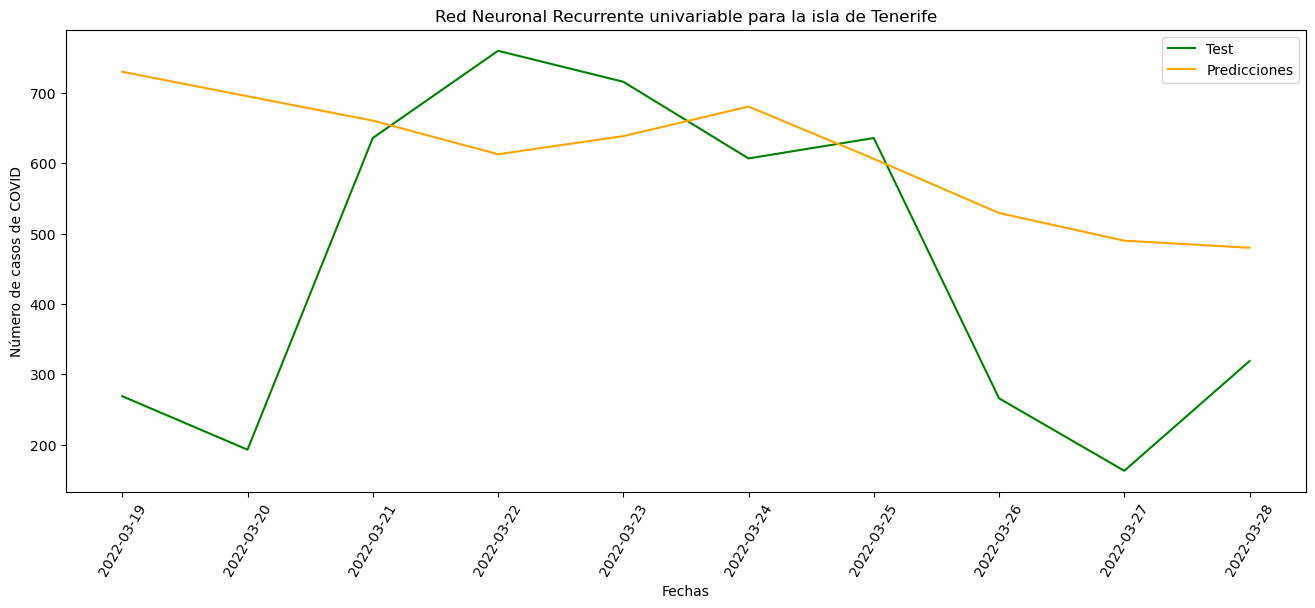

In [14]:
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [35]:
dif = y_test - y_pred
dif = dif.flatten()

In [36]:
dif

array([-461.20288086, -502.36950684,  -24.76104736,  147.02410889,
         77.32458496,  -73.69024658,   29.5335083 , -263.41833496,
       -327.07495117, -161.0440979 ])

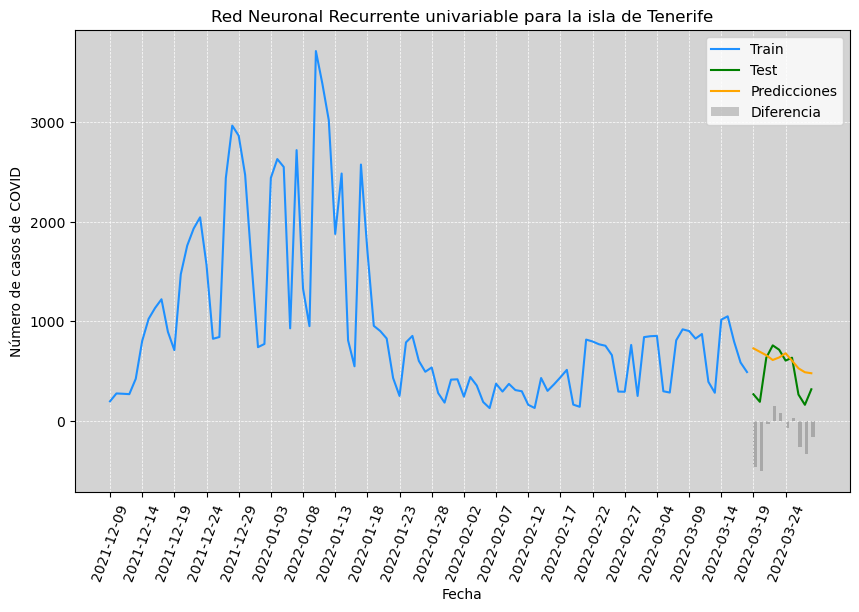

In [37]:
datos_train = datos_Tenerife_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',100,fechas,tit,color_isla,dif)

In [14]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 57236.50741616022
Error absoluto medio (MAE) del modelo: 203.52803955078124
Raíz del error cuadrático medio (RMSE) del modelo: 239.24152527552616


# Red Neuronal Recurrente multivariable con variables de pandemia

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled = scaler.fit_transform(datos_Tenerife_mult_covid)


# Escalador para las predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_covid[objetivo]).reshape(-1, 1))

In [16]:
n_train = len(datos_Tenerife_mult_covid_scaled) - dias_prediccion


train = datos_Tenerife_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_covid_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_covid_scaled), :]

In [17]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [18]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0844 - val_loss: 0.0774
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0687 - val_loss: 0.0736
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0576 - val_loss: 0.0703
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0571 - val_loss: 0.0688
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0575 - val_loss: 0.0681
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0497 - val_loss: 0.0659
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0530 - val_loss: 0.0654
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0541 - val_loss: 0.0652
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0534 - val_loss: 0.0643
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0407 - val_loss: 0.0643
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0551 - val_loss: 0.0631
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0440 - val_l

In [19]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


In [20]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 823.7214
2022-03-20: número de casos reales 193, número de casos predichos 779.7125
2022-03-21: número de casos reales 636, número de casos predichos 734.5358
2022-03-22: número de casos reales 760, número de casos predichos 687.60767
2022-03-23: número de casos reales 716, número de casos predichos 696.40247
2022-03-24: número de casos reales 607, número de casos predichos 731.6926
2022-03-25: número de casos reales 636, número de casos predichos 688.81964
2022-03-26: número de casos reales 266, número de casos predichos 649.282
2022-03-27: número de casos reales 163, número de casos predichos 620.95166
2022-03-28: número de casos reales 319, número de casos predichos 610.9758


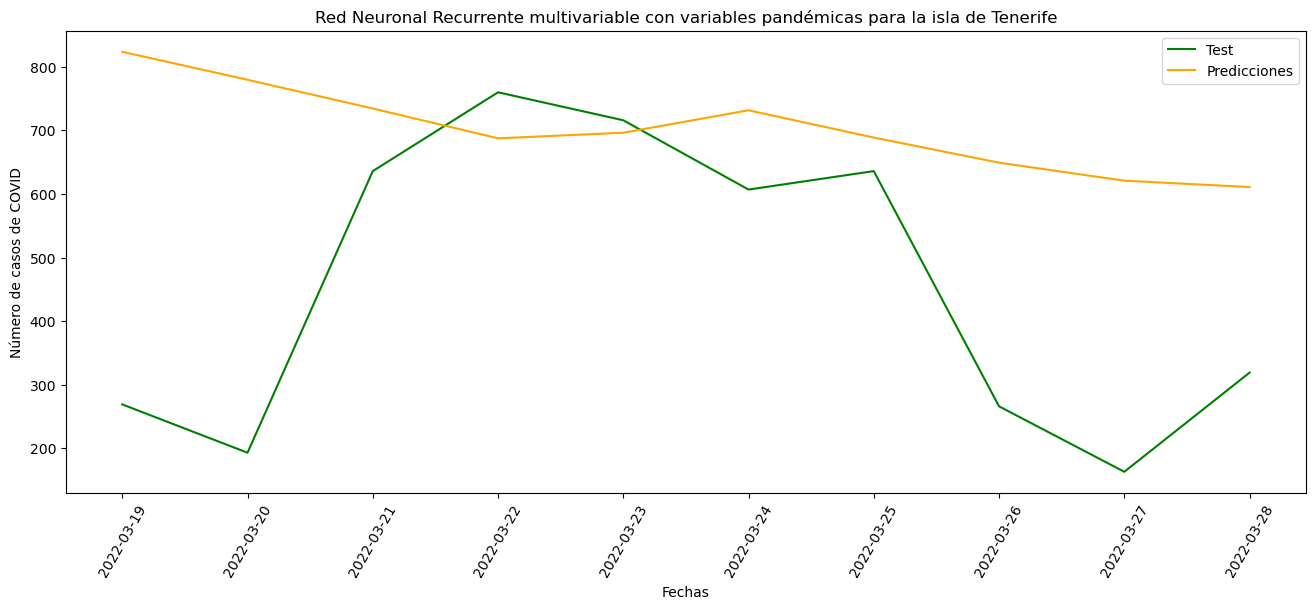

In [21]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

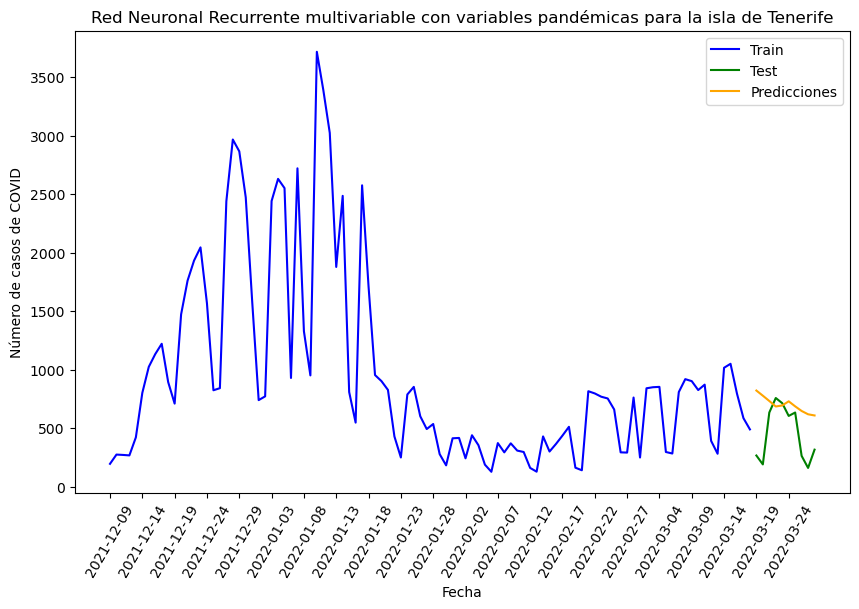

In [22]:
datos_train = datos_Tenerife_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [23]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 112749.42644809
Error absoluto medio (MAE) del modelo: 264.26813354492185
Raíz del error cuadrático medio (RMSE) del modelo: 335.7818137542443


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled = scaler.fit_transform(datos_Tenerife_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_atm[objetivo]).reshape(-1, 1))

In [25]:
n_train = len(datos_Tenerife_mult_atm_scaled) - dias_prediccion


train = datos_Tenerife_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_atm_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_atm_scaled), :]

In [26]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [27]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0959 - val_loss: 0.1157
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0943 - val_loss: 0.1062
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0785 - val_loss: 0.0979
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0810 - val_loss: 0.0788
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0750 - val_loss: 0.0741
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0635 - val_loss: 0.0707
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0621 - val_loss: 0.0756
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0615 - val_loss: 0.0645
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0565 - val_loss: 0.0649
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0565 - val_loss: 0.0632
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0551 - val_loss: 0.0669
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0517 - val

In [28]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


In [29]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 556.5692
2022-03-20: número de casos reales 193, número de casos predichos 532.3952
2022-03-21: número de casos reales 636, número de casos predichos 501.4889
2022-03-22: número de casos reales 760, número de casos predichos 467.4899
2022-03-23: número de casos reales 716, número de casos predichos 472.18286
2022-03-24: número de casos reales 607, número de casos predichos 485.24695
2022-03-25: número de casos reales 636, número de casos predichos 458.67636
2022-03-26: número de casos reales 266, número de casos predichos 433.55542
2022-03-27: número de casos reales 163, número de casos predichos 412.47812
2022-03-28: número de casos reales 319, número de casos predichos 397.80234


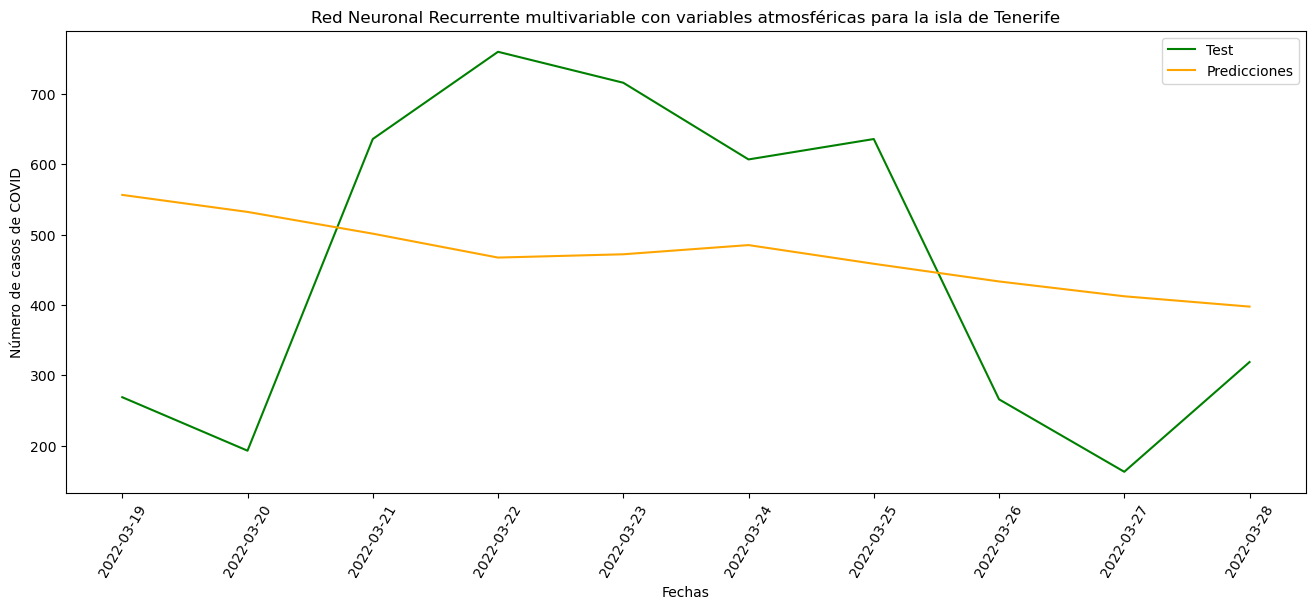

In [30]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

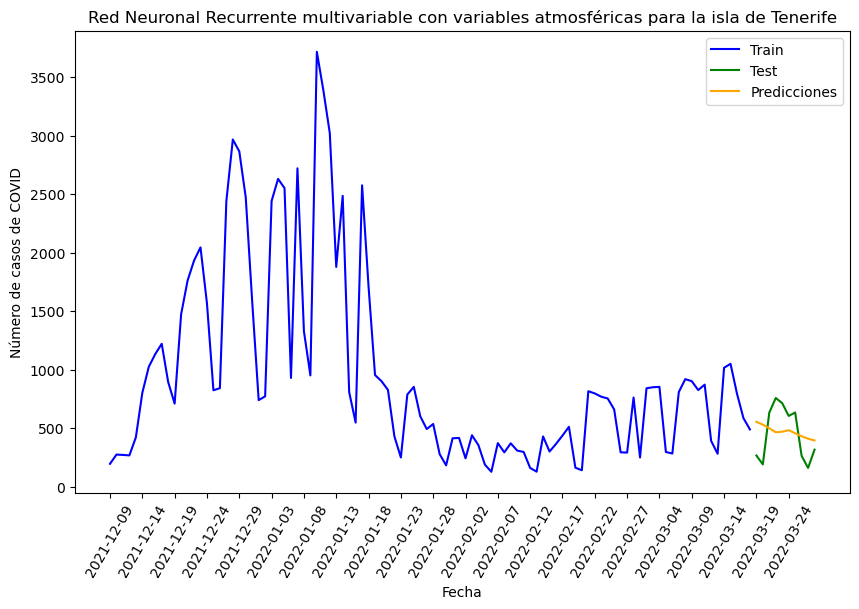

In [31]:
datos_train = datos_Tenerife_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [32]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 50377.87886056378
Error absoluto medio (MAE) del modelo: 209.271533203125
Raíz del error cuadrático medio (RMSE) del modelo: 224.45017010589183


# Red Neuronal Recurrente multivariable con todas las variables

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled = scaler.fit_transform(datos_Tenerife_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_total[objetivo]).reshape(-1, 1))

In [34]:
n_train = len(datos_Tenerife_mult_total_scaled) - dias_prediccion


train = datos_Tenerife_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_total_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_total_scaled), :]

In [35]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [36]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0958 - val_loss: 0.0941
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0706 - val_loss: 0.0734
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0548 - val_loss: 0.0712
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0573 - val_loss: 0.0699
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0535 - val_loss: 0.0683
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0604 - val_loss: 0.0675
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0533 - val_loss: 0.0671
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0542 - val_loss: 0.0657
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0526 - val_loss: 0.0674
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0556 - val_loss: 0.0644
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0464 - val_loss: 0.0632
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0439 - v

In [37]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


In [38]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 665.8854
2022-03-20: número de casos reales 193, número de casos predichos 635.10785
2022-03-21: número de casos reales 636, número de casos predichos 601.595
2022-03-22: número de casos reales 760, número de casos predichos 560.4919
2022-03-23: número de casos reales 716, número de casos predichos 590.8597
2022-03-24: número de casos reales 607, número de casos predichos 630.25604
2022-03-25: número de casos reales 636, número de casos predichos 611.6748
2022-03-26: número de casos reales 266, número de casos predichos 575.99274
2022-03-27: número de casos reales 163, número de casos predichos 535.0672
2022-03-28: número de casos reales 319, número de casos predichos 506.8589


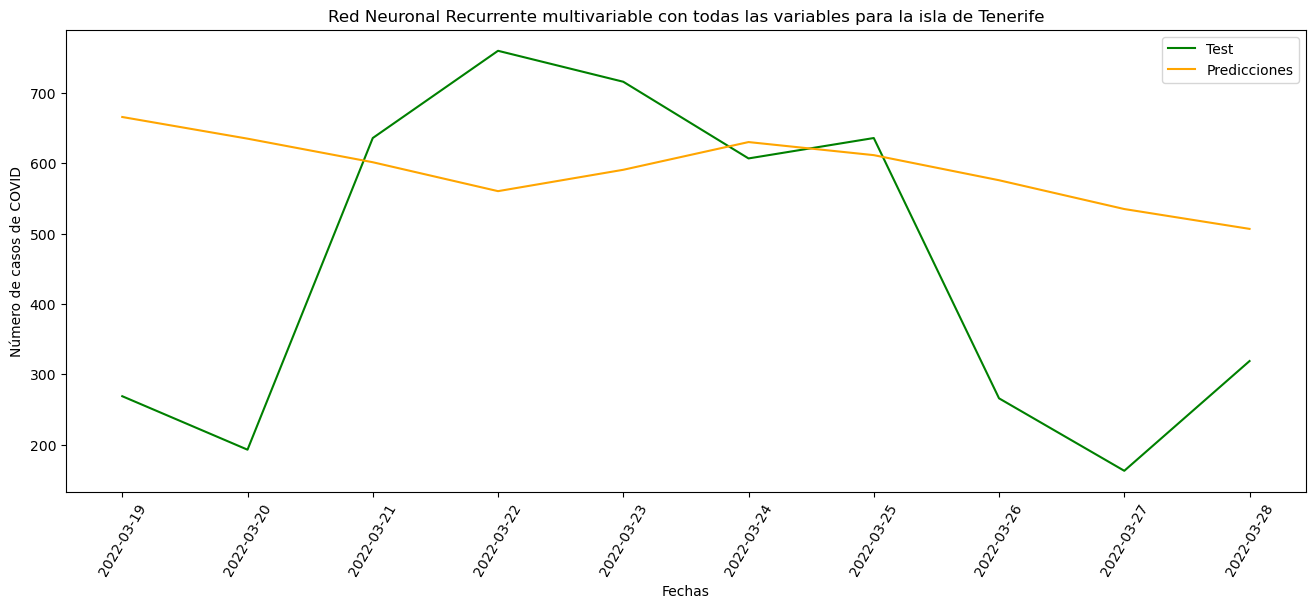

In [39]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

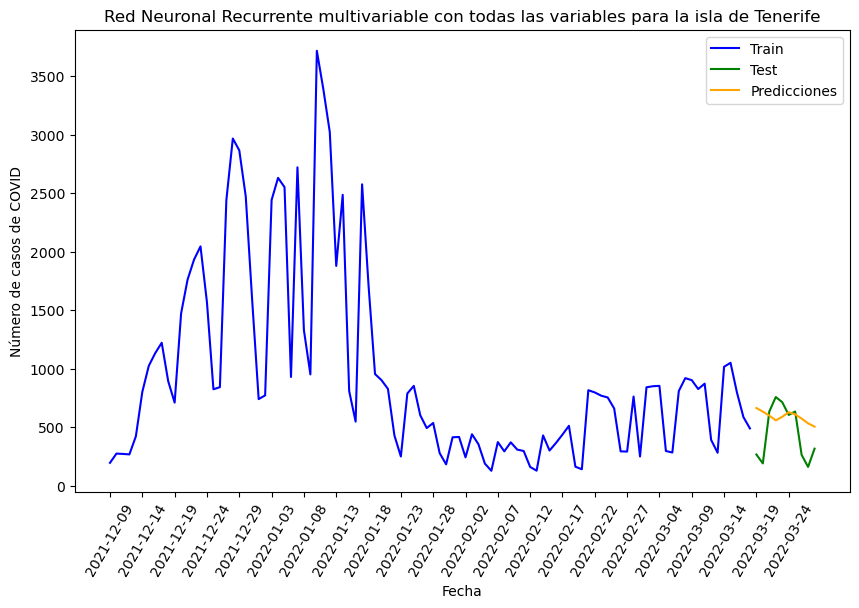

In [40]:
datos_train = datos_Tenerife_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [41]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 68057.76645585075
Error absoluto medio (MAE) del modelo: 211.55467529296874
Raíz del error cuadrático medio (RMSE) del modelo: 260.87883481771905
